In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp
import pandas as pd

In [2]:
# import cpp lib for spectrum calculation and initialize argtypes for functions in it

lib = ctypes.CDLL("./getspec.dll", winmode=0)

c_floating = ctypes.c_double;

class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_bool
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [18]:
class fit_assistant:
    def __init__(self, gamma, f0, gain, sigma, averageNum=5, Npow=16, Dt=1e-6, tau=1e-4, offset=0.2):
        
        #self.gamma = gamma
        #self.f0 = f0
        #self.gain = gain
        #self.sigma = sigma
        self.Nav = averageNum
        self.Npow = Npow
        self.Dt = Dt
        self.tau = tau
        self.offset = offset
        self.tauDt = round(np.floor(tau/Dt));
        if self.tauDt < 1:
            self.tauDt = 1
        self.tau = self.tauDt * self.Dt;  # fix tau in order to make it right value
        self.L = 2**self.Npow

        self.skip = round(self.offset * self.L);  # how many dots will be skipped by offset

        self.freqs = np.linspace(-1/2/tau, 1/2/tau, self.L)
        self.fstep = self.freqs[1] - self.freqs[0]
        self.max_freq = np.max(self.freqs)
        
        # reserve memory for sde evaluation
        self.twist = lib.reserve_twists(self.Npow)
        self.bitrev = lib.reserve_bitrev(self.Npow)
        self.Ex = lib.reserve_complex_array(self.L)
        self.Ey = lib.reserve_complex_array(self.L)
        self.tmpEx = lib.reserve_complex_array(self.L)
        self.tmpEy = lib.reserve_complex_array(self.L)
        self.specx = lib.reserve_array(self.L)
        self.specy = lib.reserve_array(self.L)
        
        self.spx = np.ctypeslib.as_array(self.specx, (self.L,))
        self.spy = np.ctypeslib.as_array(self.specy, (self.L,))
        
        self.specxloginterp = None
        self.specyloginterp = None
        self.was_evaluated = False
        self.prev_comp_result = True
        
        self.parameters = lmfit.create_params(gamma={'value' : gamma, 'min' : 0.0},
                                              f0={'value' : f0},
                                              gain={'value' : gain, 'min' : 0.0},
                                              sigma={'value' : sigma, 'min' : 0.0})
        
        
    def __del__(self):
        # free all memory
        lib.free_complex_array(self.Ex)
        lib.free_complex_array(self.Ey)
        lib.free_complex_array(self.tmpEx)
        lib.free_complex_array(self.tmpEy)
        lib.free_complex_array(self.twist)
        lib.free_array(self.specx)
        lib.free_array(self.specy)
        lib.free_uint_array(self.bitrev)
        
    
    def get_max_freq(self):
        return self.max_freq
    
    
    def compute_raw_spectrum(self, alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel):
        self.prev_comp_result = lib.sdeeval(self.specx, self.specy, self.Ex, self.Ey, self.tmpEx, self.tmpEy, 
            self.twist, self.bitrev, self.Npow, self.skip, self.Nav, self.tauDt, self.Dt, 
            alpha, kappa, 1.0, gamma_d, gamma_a, 
            gamma_p, beta, mu, C_sp, N_rel);
        # spx = np.copy(np.ctypeslib.as_array(specx, (L,)))
        # spy = np.copy(np.ctypeslib.as_array(specy, (L,)))
        # return [spx, spy]
    
    
    def internal_fit_util(self, params, frequencies=None, datax=None, datay=None):
        # data MUST be provided in logarithmic10 scale
        parvals = params.valuesdict()
        ext_f0 = parvals['f0']
        ext_gamma = parvals['gamma']
        ext_gain = np.log10(parvals['gain'])
        ext_sigma = parvals['sigma']
        spxgauss = sp.interpolate.interp1d(self.freqs, np.log10(sp.ndimage.gaussian_filter1d(self.spx, ext_sigma / self.fstep, mode="constant", cval=0.0)))
        spygauss = sp.interpolate.interp1d(self.freqs, np.log10(sp.ndimage.gaussian_filter1d(self.spy, ext_sigma / self.fstep, mode="constant", cval=0.0)))
        errx = datax - ext_gain - spxgauss((frequencies - ext_f0) / ext_gamma)
        erry = datay - ext_gain - spygauss((frequencies - ext_f0) / ext_gamma)
        return np.reshape([errx, erry], -1)
        
        
    def fit_internal(self, frequencies, datax, datay, recalculate_start_pts=True):
        """
        Fits internal parametres (f0, gain, gamma, sigma) assuming spectra already have been calculated 
        and accumulated in self.speci
        Data MUST be provided in log10 scale
        """
        if recalculate_start_pts:
            mfdx = frequencies[np.argmax(datax)]
            mfdy = frequencies[np.argmax(datay)]
            mfx = self.freqs[np.argmax(self.spx)]
            mfy = self.freqs[np.argmax(self.spy)]
            deltaf = np.max(frequencies) - np.min(frequencies)
            if abs(mfx - mfy) < 1e-4:
                # TODO : get other maxima
                return True
            self.parameters['gamma'].set( (mfdy - mfdx) / (mfy - mfx), min=0.0 )
            if self.parameters['gamma'].value < 0.01:
                return True
            f0 = (mfy*mfdx - mfdy*mfx) / (mfy - mfx)
            self.parameters['f0'].set( value=f0, min=f0-deltaf/2, max=f0+deltaf/2 )
            self.parameters['gain'].set( np.sqrt(np.max(datax) / np.max(self.spx) * np.max(datay) / np.max(self.spy)) )
        
        fit_result = lmfit.minimize(self.internal_fit_util, self.parameters, kws={'frequencies':frequencies, 'datax':datax, 'datay':datay})
        self.parameters = fit_result.params
        self.specxloginterp = sp.interpolate.interp1d(self.freqs*self.parameters['gamma'].value + self.parameters['f0'].value, 
                                                      np.log10(self.parameters['gain'].value) + np.log10(sp.ndimage.gaussian_filter1d(self.spx, self.parameters['sigma'].value / self.fstep, 
                                                                                                         mode="constant", cval=0.0)))
        self.specyloginterp = sp.interpolate.interp1d(self.freqs*self.parameters['gamma'].value + self.parameters['f0'].value, 
                                                      np.log10(self.parameters['gain'].value) + np.log10(sp.ndimage.gaussian_filter1d(self.spy, self.parameters['sigma'].value / self.fstep, 
                                                                                                         mode="constant", cval=0.0)))
        self.was_evaluated = True
        
        return False
            
    
def fit_difference(pars, fit_assistant=None, frequencies=None, datax=None, datay=None, mu=None):
    # Data MUST be providen in log10 scale
    if fit_assistant is None:
        print("Fit assistant is not provided. Aborting")
        return None
    if (datax is None) or (datay is None) or (frequencies is None):
        print("No data providen for fit. Aborting")
        return None
    parvals = pars.valuesdict()
    alpha = parvals['alpha']
    kappa = parvals['kappa']
    gamma_d = parvals['gamma_d']
    gamma_a = parvals['gamma_a']
    gamma_p = parvals['gamma_p']
    beta = parvals['beta']
    C_sp = parvals['C_sp']
    N_rel = parvals['N_rel']
    if mu is None:
        mu = parvals['mu']
    
    fit_assistant.compute_raw_spectrum(alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel)
    if not(fit_assistant.prev_comp_result):
        return 100*np.reshape([datax, datay], -1)
    ret = fit_assistant.fit_internal(frequencies, datax, datay, recalculate_start_pts=not(fit_assistant.was_evaluated))
    if ret:
        return 100*np.reshape([datax, datay], -1)
    errx = datax - fit_assistant.specxloginterp(frequencies)
    erry = datay - fit_assistant.specyloginterp(frequencies)
    return np.reshape([errx, erry], -1)

In [19]:
def read_spectrum_csv(path):
    with open(path, 'r') as file:
        next(file)
        next(file)
        start = int(next(file))
        file.close()
        return pd.read_csv(path, skiprows=start+4, names=["Frequency", "Level"], usecols=[0,1]).to_numpy()

In [20]:
Ith = 1.2582  # mA
dataX = read_spectrum_csv("../Experiments/25.05.23/X450mA.CSV")
dataY = read_spectrum_csv("../Experiments/25.05.23/Y450mA.CSV")
specX = dataX[:,1] / 10
specY = dataY[:,1] / 10
freqs = dataX[:,0] * 1000

N_rel = 0.938
mutilde = 4.5 / Ith

alpha = 3.;
kappa = 80.;
gamma = 1.;
gamma_d = 1000.;
gamma_a =  2.5;
gamma_p = 2*np.pi*9;
beta = 0.;
mu = (mutilde - N_rel) / (1 - N_rel);

C_sp = 5e-4;
N_th = 6.25e6;
N_tr = N_th * N_rel;

Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 5;

assistant = fit_assistant(gamma, 194870., 1., 0.75, averageNum=3, Npow=16, Dt=1e-6, tau=1e-4, offset=0.2)
maxf = assistant.get_max_freq()

params = lmfit.create_params(alpha={'value':alpha, 'min':0.0},
                             kappa={'value':kappa, 'min':0.0},
                             gamma_d={'value':gamma_d, 'min':0.0},
                             gamma_a={'value':gamma_a, 'min':0.0},
                             gamma_p={'value':gamma_p, 'min':0.0},
                             beta={'value':beta, 'min':-np.pi, 'max':np.pi},
                             mutilde={'value':mutilde, 'vary':False},
                             mu={'expr':"(mutilde - N_rel) / (1 - N_rel)"},
                             C_sp={'value':C_sp, 'min':0.0, 'max':1e-4},
                             N_rel={'value':N_rel, 'min':0.0, 'max':1.0})

In [21]:
%%time
res = lmfit.minimize(fit_difference, params, kws={'fit_assistant':assistant, 'frequencies':freqs, 'datax':specY, 'datay':specX}, 
                     calc_covar=False, method="ampgo", max_nfev=100)

CPU times: total: 7min 23s
Wall time: 8min 29s


In [ ]:
assistant.compute_raw_spectrum(alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel)

In [33]:
assistant.fit_internal(freqs, specY, specX, recalculate_start_pts=True)

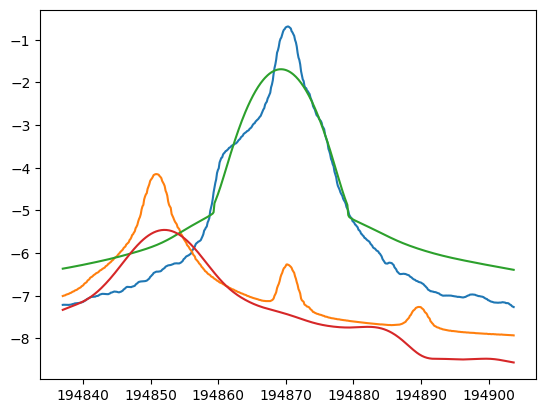

In [23]:
plt.plot(freqs, specX, freqs, specY)
plt.plot(freqs, assistant.specyloginterp(freqs), freqs, assistant.specxloginterp(freqs))
plt.show()

In [28]:
dds = fit_difference(res.params, fit_assistant=assistant, frequencies=freqs, datax=specY, datay=specX)

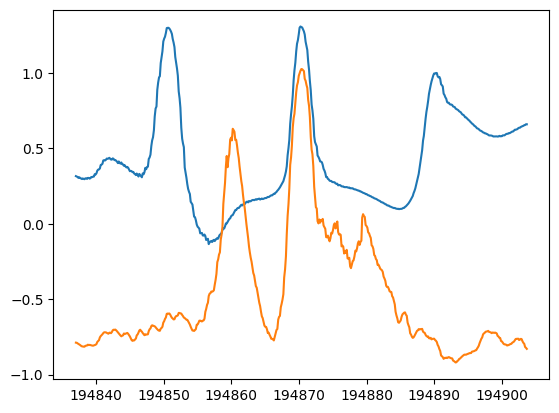

In [29]:
plt.plot(freqs, dds[0:freqs.shape[0]], freqs, dds[freqs.shape[0]:2*freqs.shape[0]])

In [25]:
assistant.parameters

name,value,initial value,min,max,vary
gamma,0.88281412,0.8808122626652217,0.00000000,inf,True
f0,194862.333,194862.3449078226,194829.080,194895.780,True
gain,5.0300e-12,5.029976435366734e-12,0.00000000,inf,True
sigma,2.76569772,2.7657012770911873,0.00000000,inf,True


In [30]:
res.params.valuesdict()

{'alpha': 3.000011503787432,
 'kappa': 80.00001133971001,
 'gamma_d': 1000.0000065262045,
 'gamma_a': 2.499960952819951,
 'gamma_p': 56.548664274503736,
 'beta': 6.239861314982775e-05,
 'mutilde': 3.57653791130186,
 'mu': 42.561320856654014,
 'C_sp': 9.999999999587075e-05,
 'N_rel': 0.9380063516222595}

In [24]:
res

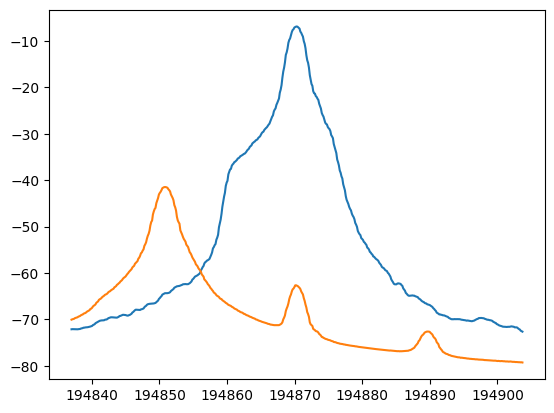

In [56]:
plt.plot(freqs, specX, freqs, specY)
plt.show()

In [82]:
(4.5/1.25-0.95)/0.05

53.00000000000001

In [77]:
ss = 1.23
pps = lmfit.create_params(gamma={'value' : ss, 'min' : 0.0}, psi={'expr':"I_th*gamma"}, I_th={'value':Ith, 'vary':False})

In [78]:
pps['gamma'].set(1.34)

In [79]:
pps

name,value,initial value,min,max,vary,expression
gamma,1.34000000,1.34,0.00000000,inf,True,
psi,1.68598800,-inf,-inf,inf,False,I_th*gamma
I_th,1.25820000,1.2582,-inf,inf,False,


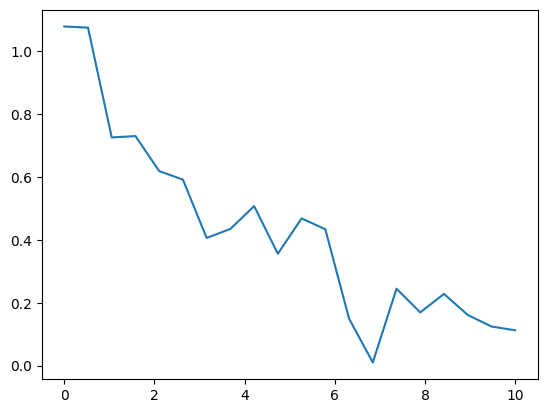

In [80]:
def tstfunc(params, x=None, data=None):
    parvals = params.valuesdict()
    ext_gamma = parvals['gamma']
    return data - np.exp(-ext_gamma * x)

# pps = lmfit.create_params(gamma={'value' : ss, 'min' : 0.0})
x = np.linspace(0, 10, 20)
y = np.exp(-0.2 * x) + np.random.normal(scale=0.1, size=x.shape)

res = lmfit.minimize(tstfunc, pps, kws={'x':x, 'data':y})

plt.plot(x,y)

In [81]:
res